# 4. Training stats (losses monitoring, early stopping)

In [38]:
import numpy as np
import torch

In [39]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)


<br/>

Nilson, T., and Kuusk, A. (1989) **A Reflectance Model for the Homogeneous Plant Canopy and Its Inversion.** Remote Sensing of Environment, 27, 157-167. doi:10.1016/0034-4257(89)90015-1

<br/>

In [40]:
# load externally generated dataset
data_dir = "data/example_4/"
X = np.loadtxt(data_dir + "X.txt", dtype=float)
y = np.loadtxt(data_dir + "y.txt", dtype=float)

In [41]:
# split original dataset in training, validation and testing sets
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_,
    y_,
    test_size=0.2,
    random_state=seed
)

In [42]:
# load input parameters and output feature names
from GPErks.serialization.labels import read_labels_from_file
xlabels = read_labels_from_file(data_dir + "xlabels.txt")
ylabel = read_labels_from_file(data_dir + "ylabel.txt")[0]  # only element of the list
print( xlabels )
print( ylabel )

['view_zenith', 'LAI', 'sl', 'lmbd_z', 'lambda']
Canopy_Reflectance


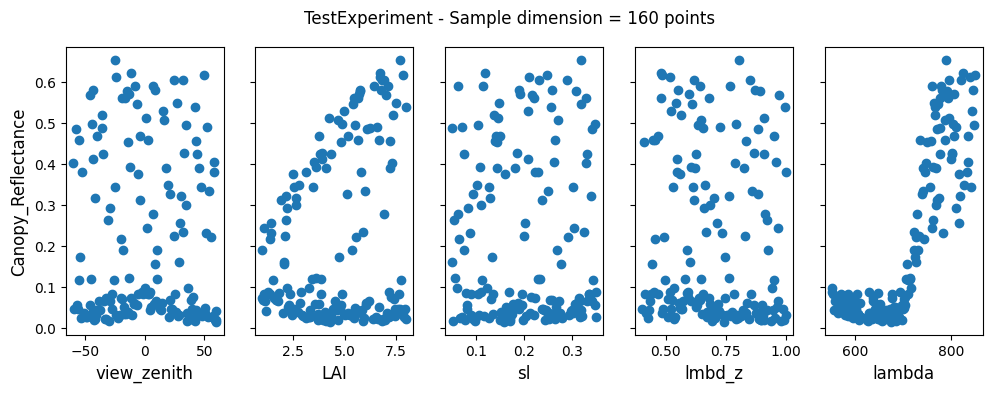

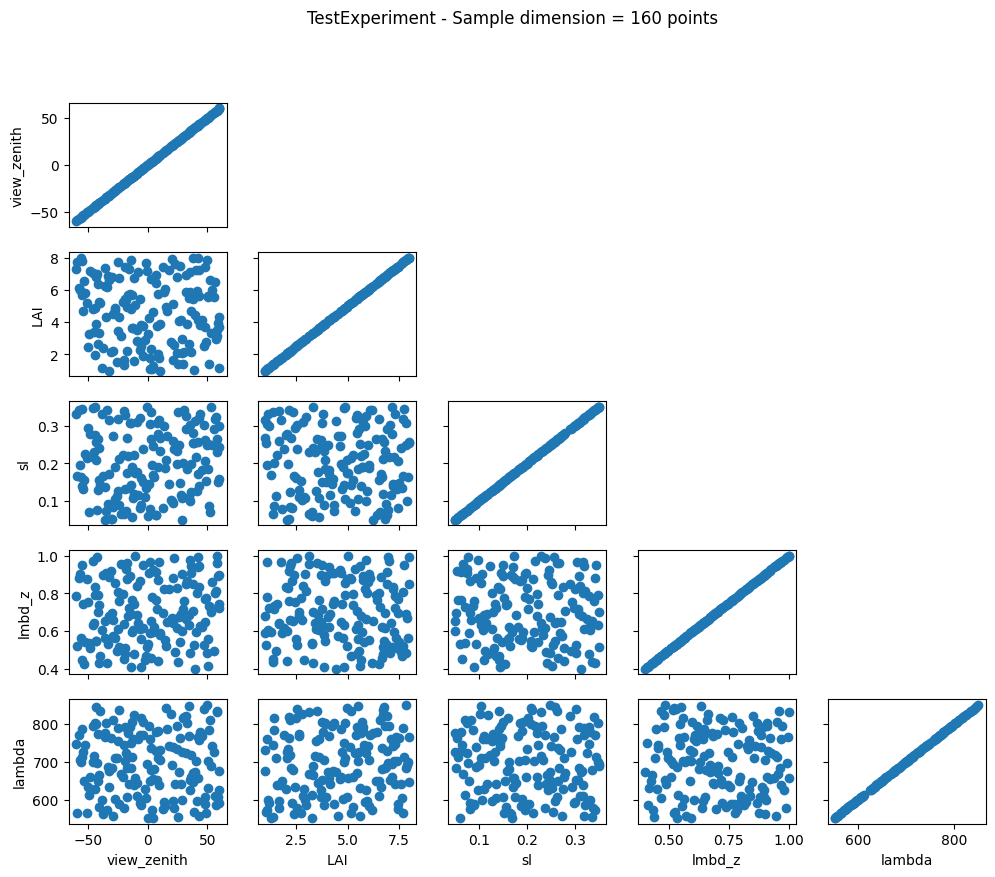

In [43]:
# build dataset
from GPErks.gp.data.dataset import Dataset
dataset = Dataset(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    x_labels=xlabels,
    y_label=ylabel
)
dataset.plot()
dataset.plot_pairwise()

In [44]:
# define experiment
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
from GPErks.gp.experiment import GPExperiment

likelihood = GaussianLikelihood()
mean_function = LinearMean(input_size=dataset.input_size)
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError(), R2Score()]

experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,  # reproducible training
    learn_noise=True
)

In [45]:
# train model
from GPErks.train.emulator import GPEmulator
device = "cpu"
optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

emulator = GPEmulator(experiment, device)
best_model, best_train_stats = emulator.train(optimizer)

INFO:2025-05-16 16:47:40,816:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:47:40,817:emulator:train:L98: Running restart 1...
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2025-05-16 16:47:40,837:emulator:_train_once:L303: [  1/100] Training Loss: 1.4702 - MeanSquaredError: 0.2549 - R2Score: 0.7451 | Validation Loss: 1.3393 - MeanSquaredError: 0.2691 - R2Score: 0.7166
INFO:2025-05-16 16:47:40,843:emulator:_train_once:L303: [  2/100] Training Loss: 1.4310 - MeanSquaredError: 0.2127 - R2Score: 0.7873 | Validation Loss: 1.3072 - MeanSquaredError: 0.2123 - R2Score: 0.7765
INFO:2025-05-16 16:47:40,850:emulator:_train_once:L303: [  3/100] Training Loss: 1.3946 - MeanSquaredError: 0.1781 - R2Score: 0.8219 | Validation Loss: 1.2774 - MeanSquaredError: 0.1710 - R2Score: 0.8199
INFO:2025-05-16 16:47:40,857:e

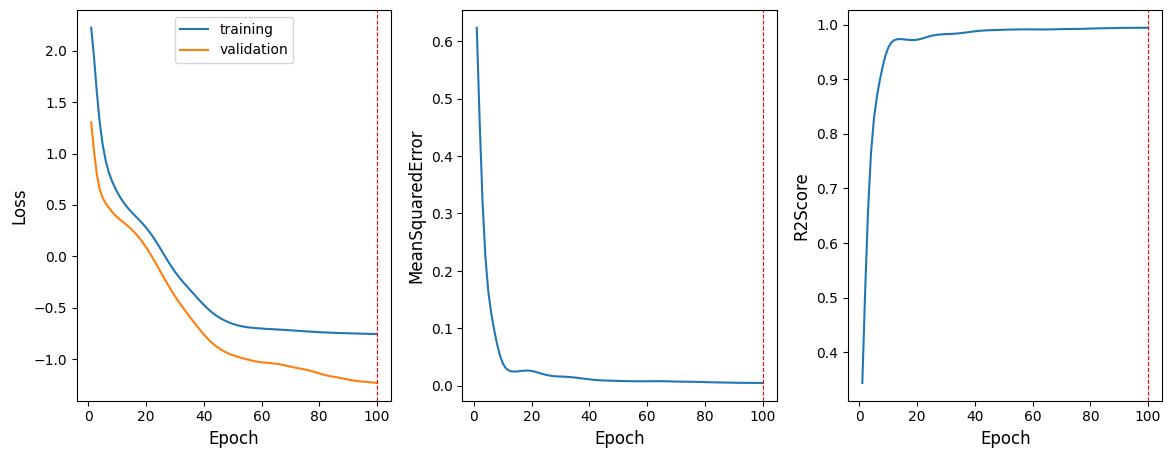

In [46]:
# examining train and val losses
best_train_stats.plot()

                   Score
MeanSquaredError  0.0002
R2Score           0.9947


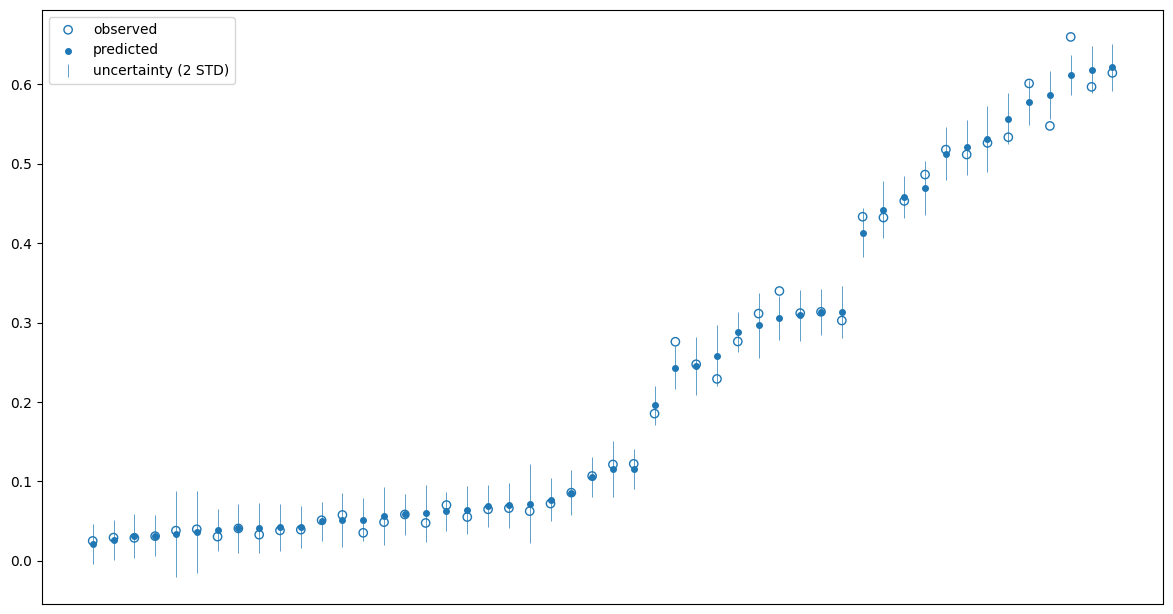

In [47]:
from GPErks.perks.inference import Inference
inference = Inference(emulator)
inference.summary()
inference.plot()

100


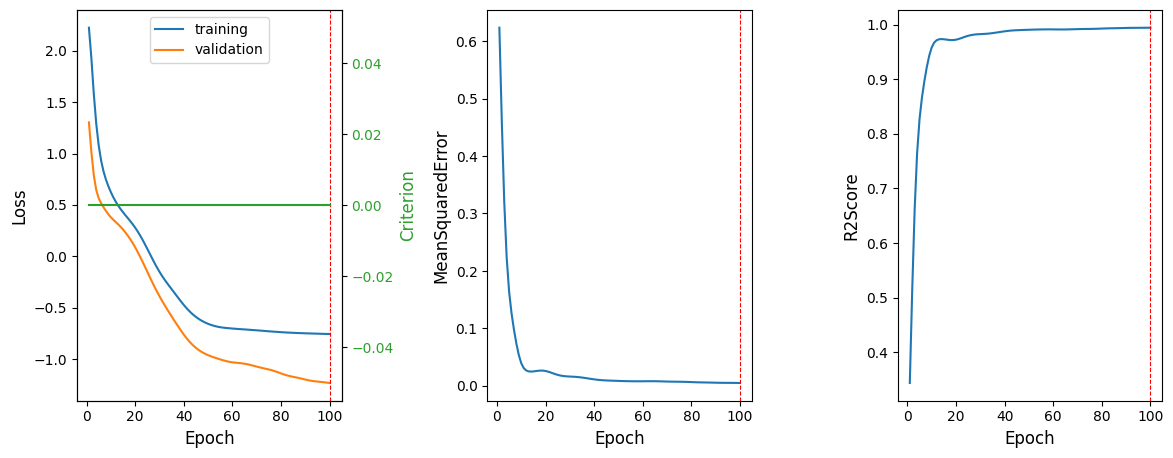

In [48]:
# early stopping criteria
print( best_train_stats.best_epoch )
best_train_stats.plot(with_early_stopping_criterion=True)

In [49]:
from GPErks.train.early_stop import NoEarlyStoppingCriterion
max_epochs = 50
esc = NoEarlyStoppingCriterion(max_epochs)

best_model, best_train_stats = emulator.train(
    optimizer,
    early_stopping_criterion=esc
)

INFO:2025-05-16 16:47:43,224:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:47:43,224:emulator:train:L98: Running restart 1...
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2025-05-16 16:47:43,274:emulator:_train_once:L303: [ 1/50] Training Loss: 1.1565 - MeanSquaredError: 0.0797 - R2Score: 0.9203 | Validation Loss: 0.8908 - MeanSquaredError: 0.1450 - R2Score: 0.8473
INFO:2025-05-16 16:47:43,290:emulator:_train_once:L303: [ 2/50] Training Loss: 1.1212 - MeanSquaredError: 0.0694 - R2Score: 0.9306 | Validation Loss: 0.8626 - MeanSquaredError: 0.1173 - R2Score: 0.8764
INFO:2025-05-16 16:47:43,297:emulator:_train_once:L303: [ 3/50] Training Loss: 1.0698 - MeanSquaredError: 0.0604 - R2Score: 0.9396 | Validation Loss: 0.8310 - MeanSquaredError: 0.0917 - R2Score: 0.9034
INFO:2025-05-16 16:47:43,304:emulato

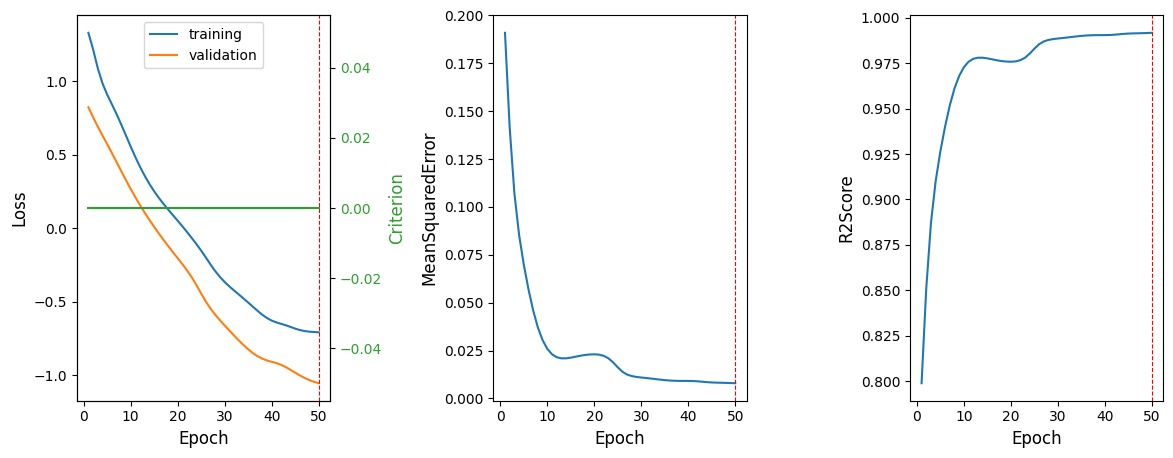

In [50]:
best_train_stats.plot(with_early_stopping_criterion=True)


<br/>

Prechelt L. (2012) **Early Stopping — But When?.** In: Montavon G., Orr G.B., Müller KR. (eds) Neural Networks: Tricks of the Trade. Lecture Notes in Computer Science, vol 7700. Springer, Berlin, Heidelberg. doi:10.1007/978-3-642-35289-8_5

<br/>


In [51]:
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion,
)
max_epochs = 1000

esc = GLEarlyStoppingCriterion(
        max_epochs, alpha=0.1, patience=8
)
# esc = PQEarlyStoppingCriterion(
#     max_epochs, alpha=1, patience=8, strip_length=5
# )
# esc = UPEarlyStoppingCriterion(
#     max_epochs, strip_length=5, successive_strips=4
# )

best_model, best_train_stats = emulator.train(
    optimizer,
    early_stopping_criterion=esc
)

INFO:2025-05-16 16:47:44,381:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:47:44,382:emulator:train:L98: Running restart 1...
INFO:2025-05-16 16:47:44,432:emulator:_train_once:L303: [   1/1000] Training Loss: 0.6680 - MeanSquaredError: 0.0578 - R2Score: 0.9422 | Validation Loss: 0.3523 - MeanSquaredError: 0.0745 - R2Score: 0.9216
INFO:2025-05-16 16:47:44,447:emulator:_train_once:L303: [   2/1000] Training Loss: 0.6262 - MeanSquaredError: 0.0527 - R2Score: 0.9473 | Validation Loss: 0.2991 - MeanSquaredError: 0.0652 - R2Score: 0.9313
INFO:2025-05-16 16:47:44,456:emulator:_train_once:L303: [   3/1000] Training Loss: 0.5733 - MeanSquaredError: 0.0468 - R2Score: 0.9532 | Validation Loss: 0.2402 - MeanSquaredError: 0.0551 - R2Score: 0.9420
INFO:2025-05-16 16:47:44,465:emulator:_train_once:L303: [   4/1000] Training Loss: 0.5116 - MeanSquaredError: 0.0407 - R2Score: 0.9593 | Validation Loss: 0.1805 - MeanSquaredError: 0.0461 - R2Score: 0.9514
INFO:2025-05-16 16:47:44,473:emulato

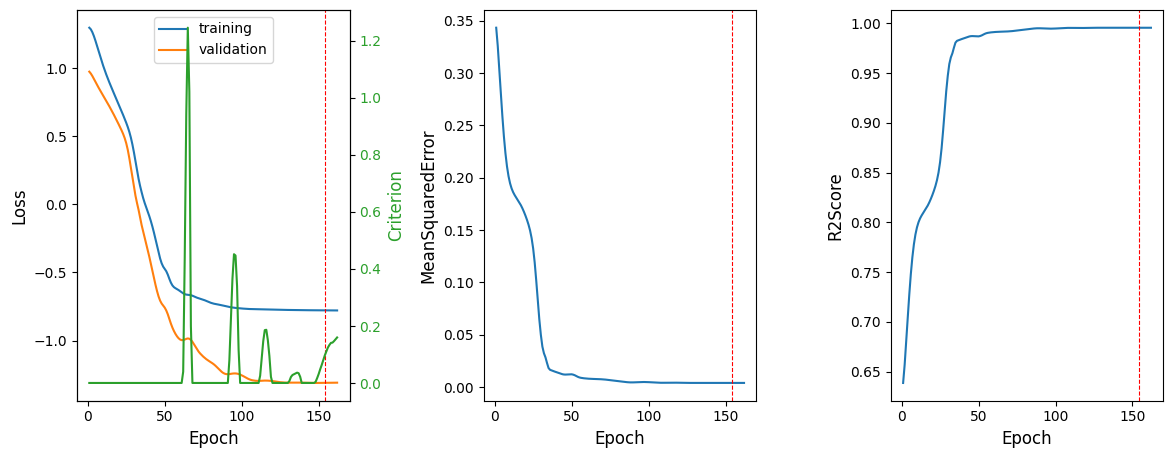

In [52]:
best_train_stats.plot(with_early_stopping_criterion=True)

In [53]:
from GPErks.train.early_stop import PkEarlyStoppingCriterion
esc = PkEarlyStoppingCriterion(
    max_epochs, alpha=0.01, patience=8, strip_length=20
)

emulator.scaled_data.with_val = False  # let's pretend we don't have a val set

_, best_train_stats = emulator.train(
    optimizer,
    early_stopping_criterion=esc
)

INFO:2025-05-16 16:47:47,891:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:47:47,892:emulator:train:L98: Running restart 1...
INFO:2025-05-16 16:47:47,937:emulator:_train_once:L303: [   1/1000] Training Loss: 2.4092 - MeanSquaredError: 0.5614 - R2Score: 0.4386
INFO:2025-05-16 16:47:47,951:emulator:_train_once:L303: [   2/1000] Training Loss: 2.2100 - MeanSquaredError: 0.5020 - R2Score: 0.4980
INFO:2025-05-16 16:47:47,956:emulator:_train_once:L303: [   3/1000] Training Loss: 1.9330 - MeanSquaredError: 0.4369 - R2Score: 0.5631
INFO:2025-05-16 16:47:47,961:emulator:_train_once:L303: [   4/1000] Training Loss: 1.6694 - MeanSquaredError: 0.3754 - R2Score: 0.6246
INFO:2025-05-16 16:47:47,967:emulator:_train_once:L303: [   5/1000] Training Loss: 1.4589 - MeanSquaredError: 0.3228 - R2Score: 0.6772
INFO:2025-05-16 16:47:47,972:emulator:_train_once:L303: [   6/1000] Training Loss: 1.3051 - MeanSquaredError: 0.2806 - R2Score: 0.7194
INFO:2025-05-16 16:47:47,977:emulator:_train_once:

In [54]:
inference = Inference(emulator)
inference.summary()
best_train_stats.best_epoch == max_epochs

                   Score
MeanSquaredError  0.0002
R2Score           0.9948


False

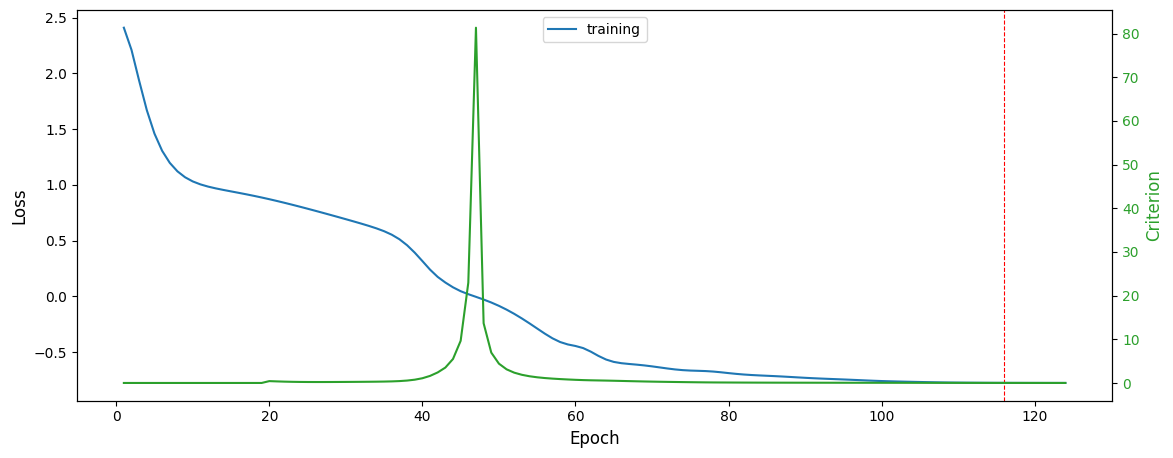

In [55]:
best_train_stats.plot(with_early_stopping_criterion=True)

we were able to stop training very early, which is good since it prevents overfitting;
however, we advise not to rely solely on training loss and to always use a validation set when training